In [1]:
from pathlib import Path
import os

from dataclasses import dataclass
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

import random
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import HTML
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

import torch
import torch.nn.functional as F

from diffusers import UNet2DConditionModel, DDPMScheduler, DDPMPipeline, DDIMScheduler
from diffusers import AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer, logging
from accelerate import Accelerator
from torchvision import transforms

2025-05-20 11:30:47.224946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747740647.416621      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747740647.472087      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
@dataclass
class TrainConfig:
    image_size = 256
    latent_size = 16

    train_batch_size = 96
    eval_batch_size = 16
    eval_steps = 50

    num_epochs = 10
    save_image_epochs = 1
    save_model_epochs = 1
    start_from_checkpoint = True

    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 0

    uncond_prob = 0.15

    mixed_precision = "fp16"
    output_dir = "cc_2"
    seed = 32

config = TrainConfig()
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
%%bash

ls /kaggle/input/celeba-with-captions/image/image/

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1000.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1001.jpg
10020.jpg
10021.jpg
10022.jpg
10023.jpg
10024.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
10029.jpg
1002.jpg
10030.jpg
10031.jpg
10032.jpg
10033.jpg
10034.jpg
10035.jpg
10036.jpg
10037.jpg
10038.jpg
10039.jpg
1003.jpg
10040.jpg
10041.jpg
10042.jpg
10043.jpg
10044.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
10049.jpg
1004.jpg
10050.jpg
10051.jpg
10052.jpg
10053.jpg
10054.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1005.jpg
10060.jpg
10061.jpg
10062.jpg
10063.jpg
10064.jpg
10065.jpg
10066.jpg
10067.jpg
10068.jpg
10069.jpg
1006.jpg
10070.jpg
10071.jpg
10072.jpg
10073.jpg
10074.jpg
10075.jpg
10076.jpg
10077.jpg
10078.jpg
10079.jpg
1007.jpg
10080.jpg
10081.jpg
10082.jpg
10083.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
10089.jpg
1008.jpg
10090.jpg
100

In [23]:
import json

with open("/kaggle/input/celeba-with-captions/captions_hq.json", 'r') as f:
    cc = json.load(f)
    # cc = [info['overall_caption'] for info in cc.values()]

In [27]:
import json

class ImageFolderDataset(Dataset):
    def __init__(self, img_folder, cc_json, transform=None):
        self.image_paths = [os.path.join(img_folder, fname) 
                            for fname in os.listdir(img_folder)
                            if fname.lower().endswith(('.jpg'))]
        self.image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        self.transform = transform
        with open(cc_json, 'r') as f:
            self.cc = json.load(f)
        self.cc["5380.jpg"] = {
            "overall_caption": ""
        }

        # Sort keys numerically to align with image_paths
        sorted_keys = sorted(self.cc.keys(), key=lambda x: int(os.path.splitext(x)[0]))
        # Extract captions in sorted order
        self.cc = [self.cc[k]["overall_caption"] for k in sorted_keys]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        prompt = self.cc[idx]
        return {
            'image':image,
            'prompt':prompt,
        }

transform = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

dataset = ImageFolderDataset("/kaggle/input/celeba-with-captions/image/image/", "/kaggle/input/celeba-with-captions/captions_hq.json", transform=transform)

In [4]:
config.dataset_name = "Ryan-sjtu/celebahq-caption"

dataset = load_dataset(config.dataset_name)

README.md:   0%|          | 0.00/248 [00:00<?, ?B/s]

(…)-00000-of-00006-79db0fe6de88169a.parquet:   0%|          | 0.00/460M [00:00<?, ?B/s]

(…)-00001-of-00006-0f8d0d959cec8916.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

(…)-00002-of-00006-f24bdc31643a8cc9.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

(…)-00003-of-00006-95bad2a0b754bd1a.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00004-of-00006-07aaca849f5cd66b.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

(…)-00005-of-00006-dafd16986a4296b9.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset['train']

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

#########################Embeed the the prompt
def transform(examples):
    image = [preprocess(img.convert("RGB")) for img in examples['image']]
    prompt = examples['text']
    return {
        "image": torch.stack(image),
        "prompt": prompt,
    }

dataset.set_transform(transform)

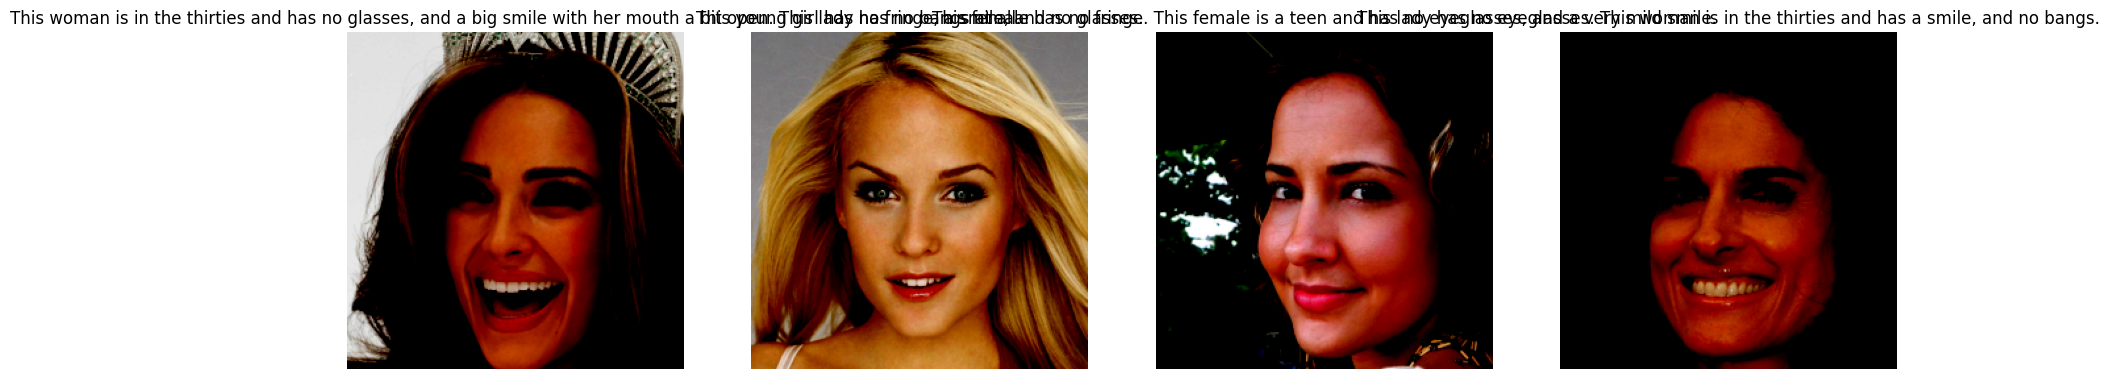

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(dataset[i]['image'].permute(1, 2, 0))
    axs[i].set_axis_off()
    axs[i].set_title(dataset[i]['prompt'])

fig.savefig('example.png')
fig.show()

In [3]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

vae = vae.to(torch_device)
text_encoder.to(torch_device)

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [10]:
def img_to_latent(input_im):
    #Image tensor (B, 3, 256, 256) -> Latent (B, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(input_im.to(torch_device)*2 - 1)
    return 0.18215 * latent.latent_dist.sample()

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

all_latents = []
for idx, batch in enumerate(dataloader):
    lat = img_to_latent(batch["image"])
    # move back to CPU and store
    all_latents.append(lat)
    if idx % 16 == 0:
        print(f"Processed {idx * dataloader.batch_size} images")

Processed 0 images
Processed 512 images
Processed 1024 images
Processed 1536 images
Processed 2048 images
Processed 2560 images
Processed 3072 images
Processed 3584 images
Processed 4096 images
Processed 4608 images
Processed 5120 images
Processed 5632 images
Processed 6144 images
Processed 6656 images
Processed 7168 images
Processed 7680 images
Processed 8192 images
Processed 8704 images
Processed 9216 images
Processed 9728 images
Processed 10240 images
Processed 10752 images
Processed 11264 images
Processed 11776 images
Processed 12288 images
Processed 12800 images
Processed 13312 images
Processed 13824 images
Processed 14336 images
Processed 14848 images
Processed 15360 images
Processed 15872 images
Processed 16384 images
Processed 16896 images
Processed 17408 images
Processed 17920 images
Processed 18432 images
Processed 18944 images
Processed 19456 images
Processed 19968 images
Processed 20480 images
Processed 20992 images
Processed 21504 images
Processed 22016 images
Processed 22

IndexError: Caught IndexError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_75/244455484.py", line 21, in __getitem__
    prompt = self.cc[idx]
             ~~~~~~~^^^^^
IndexError: list index out of range


In [4]:
all_latents_cpu = [l.cpu() for l in all_latents]
all_latents_cpu = torch.cat(all_latents_cpu, dim=0)
torch.save(all_latents_cpu, "all_latents_tensor.pt")

NameError: name 'all_latents' is not defined

In [13]:
all_latents_cpu.shape

torch.Size([29984, 4, 32, 32])

In [18]:
len(dataset)

30000

In [ ]:
dataset.cc[:]

29999

In [45]:
all_prompts_tokenized = []
tokenize_batch = 1024
i = 0

dataloader = DataLoader(
    dataset,
    batch_size=tokenize_batch,
    shuffle=False,
    num_workers=2,
)

for idx, batch in enumerate(dataloader):
   temp = tokenizer(batch['prompt'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
   all_prompts_tokenized.append(temp.input_ids)
   if i % 5*1024 == 0:
      print(i)
   i += tokenize_batch

0
5120
10240
15360
20480
25600


In [48]:
all_prompts_tokenized = torch.cat(all_prompts_tokenized, dim=0)
torch.save(all_prompts_tokenized, 'all_prompts_tokenized.pt')

In [4]:
all_latents_tensor = torch.load("all_latents_tensor.pt", map_location="cpu")
all_prompts_tokenized = torch.load("all_prompts_tokenized.pt", map_location="cpu")

In [5]:
all_latents_tensor = all_latents_tensor[:29952]
all_prompts_tokenized = all_prompts_tokenized[:29952]

Creating and Training LDM

In [7]:
class TextLatentDataset(Dataset):
    def __init__(self, latents, prompts):
        self.latents = latents  # [N, C, H, W]
        self.prompts = prompts  # [N, 77]

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        latent = 0.18215 * self.latents[idx] ######Very Important Scaling#######
        prompt = self.prompts[idx]
        return {
            "latent": latent,
            "prompt_ids": prompt,
        }

dataset = TextLatentDataset(all_latents_tensor, all_prompts_tokenized)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=2, prefetch_factor=2)

In [10]:
unet = UNet2DConditionModel(
    sample_size=32,             # 32x32 resolution
    in_channels=4,              # latent channels
    out_channels=4,             # predict noise (or v)
    cross_attention_dim=768,    # text embedding dimension (CLIP/BERT)
    attention_head_dim=8,
    block_out_channels=[128, 256, 512],
    layers_per_block=2,
    down_block_types=(
        "CrossAttnDownBlock2D",   # 32 -> 16
        "CrossAttnDownBlock2D",   # 16 -> 8
        "CrossAttnDownBlock2D",   # 8 -> 4
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",     # 4 -> 8
        "CrossAttnUpBlock2D",     # 8 -> 16
        "CrossAttnUpBlock2D",     # 16 -> 32
    )
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="epsilon")

In [12]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [ ]:
eval_fixed_prompt = all_prompts_tokenized[:config.eval_batch_size]
eval_fixed_prompt = eval_fixed_prompt.to(torch_device)

with torch.no_grad():
    eval_fixed_embedd = text_encoder(eval_fixed_prompt)["last_hidden_state"]

latents = all_latents_tensor[:config.eval_batch_size]

def evaluate(config, epoch, inf_timesteps, model, scheduler_typ, eta = 1, eval_fixed_embedd=eval_fixed_embedd):
    if scheduler_typ=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_typ=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    scheduler.set_timesteps(inf_timesteps)
    scheduler.timesteps = scheduler.timesteps.to(torch_device)
    
    B, C, H, W = config.eval_batch_size, 4, 32, 32
    latents = torch.randn((B, C, H, W), device=torch_device)

    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = model(latents, t, encoder_hidden_states=eval_fixed_embedd).sample
        
        if scheduler_typ == "ddim":
            latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
        elif scheduler_typ == "ddpm":
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    avg_latents = latents.mean(dim=1)

    grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

    path = Path(f"./{config.output_dir}/samples")
    path.mkdir(parents=True, exist_ok=True)

    img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img1.save(f"./{config.output_dir}/samples/eval_latents_{epoch}.png")
    
    # latents = (1 / 0.18215) * latents

    # with torch.no_grad():
    #     image = vae.decode(latents).sample
    
    # grid = make_grid(image, nrow=4, padding=2)

    # img2 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    # img2.save(f"./{config.output_dir}/samples/eval_decoded_{epoch}.png")

    # return img2

In [9]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    uncond_input = tokenizer([""]*config.train_batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt").input_ids
    uncond_input = uncond_input.to(torch_device)

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Training Loop
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            latents = batch["latent"]
            prompts = batch["prompt_ids"]

            if torch.rand(1).item() < 0.13: ### To Enable Classifier Free Guidance
                prompts = uncond_input

            with torch.no_grad():
                text_embeddings = text_encoder(prompts)["last_hidden_state"]

            # Sample noise to add to the images
            noise = torch.randn_like(latents).to(torch_device)
            bs = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=torch_device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_latents, timesteps, encoder_hidden_states=text_embeddings, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, config.eval_steps, model, "ddim", eta = 1)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(os.path.join(config.output_dir, f"checkpoint_{epoch}"))

In [6]:

unet = UNet2DConditionModel.from_pretrained(os.path.join("cc_2", f"checkpoint_9", "unet"))
noise_scheduler = DDPMScheduler.from_pretrained(os.path.join("cc_2", f"checkpoint_9", "scheduler"))

unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 128, eps=1e-06, affine=True)
          (proj_in): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=128, out_features=128, bias=False)
                (to_k): Linear(in_features=128, out_features=128, bias=False)
                (to_v): Linear(in_features=128, out_featu

In [13]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [14]:
from accelerate import notebook_launcher

args = (config, unet, noise_scheduler, optimizer, dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
torch.cuda.empty_cache()

Loading Checkpoint

In [55]:
eval_fixed_prompt = all_prompts_tokenized[:config.eval_batch_size]
eval_fixed_prompt = eval_fixed_prompt.to(torch_device)

with torch.no_grad():
    eval_fixed_embedd = text_encoder(eval_fixed_prompt)["last_hidden_state"]

latents = all_latents_tensor[:config.eval_batch_size]

def latents_to_pil(latents):
    #Latent(B, 4, 64, 64) -> Image (3, 512, 512)
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def evaluate(config, epoch, inf_timesteps, model, scheduler_typ, eta = 1, eval_fixed_embedd=eval_fixed_embedd):
    if scheduler_typ=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_typ=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    scheduler.set_timesteps(inf_timesteps)
    scheduler.timesteps = scheduler.timesteps.to(torch_device)
    
    B, C, H, W = config.eval_batch_size, 4, 32, 32
    latents = torch.randn((B, C, H, W), device=torch_device)

    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = model(latents, t, encoder_hidden_states=eval_fixed_embedd).sample
        
        if scheduler_typ == "ddim":
            latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
        elif scheduler_typ == "ddpm":
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents = (1 / 0.18215) * latents

    avg_latents = latents.mean(dim=1)

    grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

    path = Path(f"./{config.output_dir}/samples")
    path.mkdir(parents=True, exist_ok=True)

    img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img1.save(f"./{config.output_dir}/samples/eval_latents_{epoch}.png")

    latents = (1 / 0.18215) * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
    
    grid = make_grid(image, nrow=4, padding=2)

    img2 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img2.save(f"./{config.output_dir}/samples/eval_decoded_{epoch}.png")

    return img1, img2

  0%|          | 0/50 [00:00<?, ?it/s]

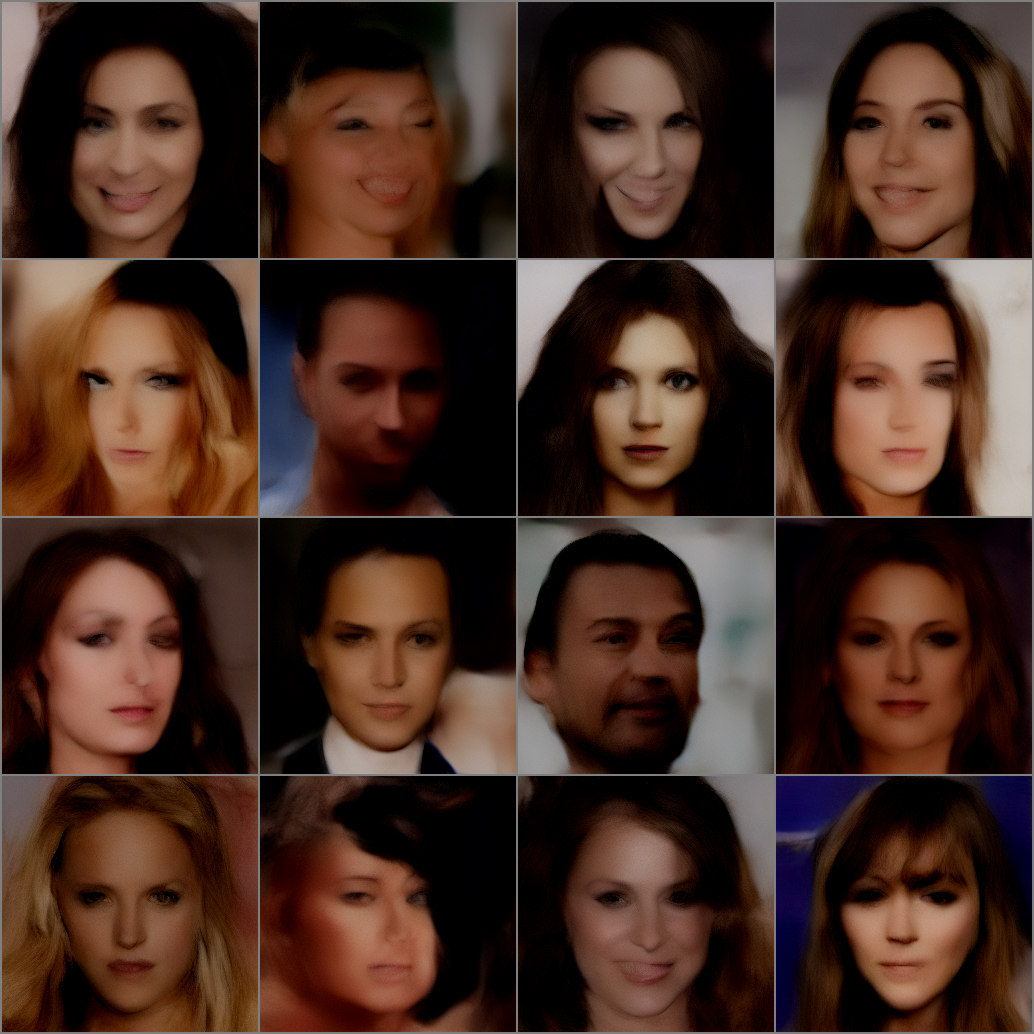

In [57]:
img1, img2 = evaluate(config, 69, 50, unet, "ddim", eta = 1, eval_fixed_embedd=eval_fixed_embedd)
img2

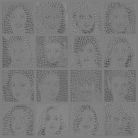

In [46]:
img1

In [32]:
from torchvision import transforms as tfms

def pil_to_latents(input_im):
    #Image (B, 3, 512, 512) -> Latent(B, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(input_im.to(torch_device)*2 -1)
    return 0.18215 * latent.latent_dist.sample()

In [38]:
# dataset[0]['image']
imgs = torch.cat([dataset[i]['image'].unsqueeze(0) for i in range(16)], dim=0)

In [39]:
imgs.shape

torch.Size([16, 3, 256, 256])

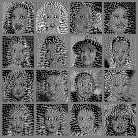

In [40]:
latents = pil_to_latents(imgs)

avg_latents = latents.mean(dim=1)

grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
img1

In [130]:
for i, p in enumerate(all_prompts_tokenized[100:200]):
    decoded = tokenizer.decode(p, skip_special_tokens=True)
    print(f"[{i}] {decoded}")

[0] this guy doesn 't have any beard at all . this man is in his thirties and has no smile , and no glasses . the whole forehead is visible without any fringe .
[1] there is not any eyeglasses on the face and has no fringe , and no smile . she is a young adult .
[2] this person has no bangs , no smile , and no eyeglasses . this woman is a young adult .
[3] this female is not wearing any eyeglasses and has no smile , and no fringe . this lady is a young adult .
[4] this lady in the thirties has long bangs that almost covers this full forehead , no glasses , and a smile with the teeth visible .
[5] this female has no bangs , and no glasses . she is in the thirties and has a smile with her teeth visible .
[6] she is not wearing any glasses and has no bangs , and a mild smile . this woman is a young adult .
[7] this lady has no fringe at all . this lady is a teenager and has no smile , and no eyeglasses .
[8] this young person has no glasses , and no bangs . this lady has a beaming face .


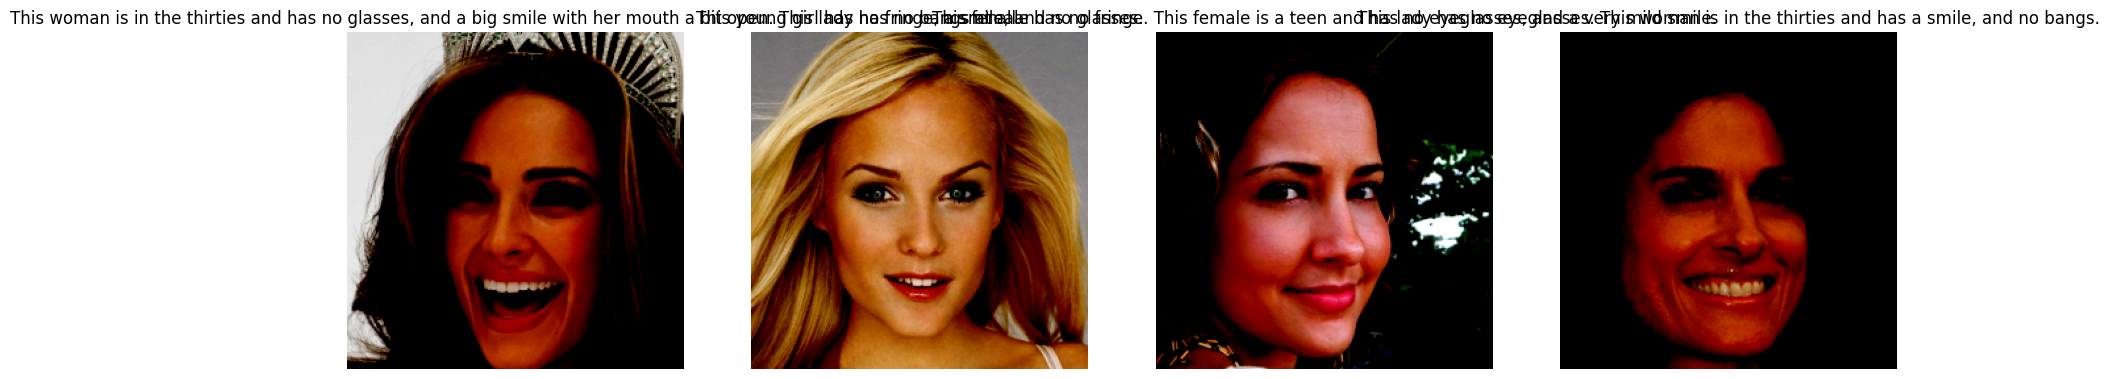

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(dataset[i]['image'].permute(1, 2, 0))
    axs[i].set_axis_off()
    axs[i].set_title(dataset[i]['prompt'])

fig.savefig('example.png')
fig.show()

In [76]:
torch_device

device(type='cuda')

In [104]:
torch.tensor([3])

tensor([3])

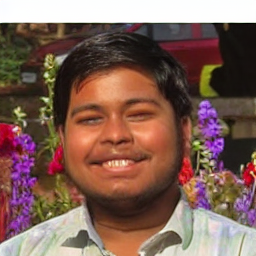

In [116]:
latents_to_pil(pil_to_latents(Image.open("/kaggle/input/ommmmm/om256.png")))[0]

In [ ]:
import torchvision.transforms as T

def pil_to_latents(input_im):
    #Image (3, 512, 512) -> Latent(1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 -1)
    return 0.18215 * latent.latent_dist.sample()

def text_to_img_grid(config, unet, prompt, inference_step_list, guidance_list, scheduler_class, eta=1.0, custom=None):
    height = config.image_size
    width = config.image_size
    generator = torch.Generator(device=torch_device).manual_seed(31)
    batch_size = 1  # assuming single prompt        

    # Tokenize input
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # Unconditioned text
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    fig, axs = plt.subplots(len(inference_step_list), len(guidance_list), figsize=(5*len(guidance_list) ,5*len(inference_step_list)))
    fig.suptitle(prompt[0], fontsize=20)

    if scheduler_class=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_class=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    if custom is not None:
        print("custom")

    for j, guidance_scale in tqdm(enumerate(guidance_list), total=len(guidance_list)):
        for i, num_inference_steps in enumerate(inference_step_list):
        
            scheduler.set_timesteps(num_inference_steps)

            if custom is not None:
                latents = pil_to_latents(Image.open(custom))
                latents = latents.expand(batch_size, -1, -1, -1).clone()
                noise = torch.randn(
                    (batch_size, unet.in_channels, height // 8, width // 8),
                    device=torch_device,
                )
                latents = scheduler.add_noise(latents, noise, torch.tensor([100], device=torch_device))
            else:
                latents = torch.randn(
                    (batch_size, unet.in_channels, height // 8, width // 8),
                    generator=generator,
                    device=torch_device,
                )

            # Expand the embeddings to shape (2, batch, dim)
            cond_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

            for t in scheduler.timesteps:
                latent_input = torch.cat([latents] * 2)
                with torch.no_grad():
                    noise_pred = unet(latent_input, t, encoder_hidden_states=cond_embeddings).sample

                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if scheduler_class == "ddim":
                    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
                elif scheduler_class == "ddpm":
                    latents = scheduler.step(noise_pred, t, latents).prev_sample

            latents = (1 / 0.18215) * (1 / 0.18215) * latents
            with torch.no_grad():
                image = vae.decode(latents).sample

            image = (image / 2 + 0.5).clamp(0, 1)
            axs[i, j].imshow(image.cpu()[0].permute(1,2,0).numpy())
            axs[i, j].set_axis_off()
            axs[i, j].set_title(f"scale {guidance_list[j]} | step {inference_step_list[i]}")
    fig.savefig(f"{prompt[0]}.png")
    fig.show()

# Example usage:
grid_img = text_to_img_grid(
    config=config,
    unet=unet,
    prompt=["this teenager has short beard , glasses , and no smile and his long hairs covers all of the forehead .."],
    inference_step_list=[20, 50],
    guidance_list=[0.0, 2.0, 4.0, 8.0, 10],
    scheduler_class="ddim",
    eta=1.0,
    custom = None
)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_75/165018498.py:52: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [141]:
!rm *.png

/tmp/ipykernel_75/1470211993.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height//8, width//8),


0it [00:00, ?it/s]

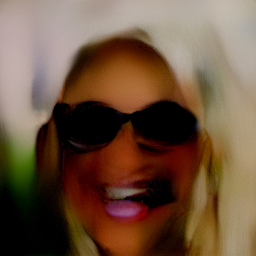

In [ ]:
prompt = ["this young girl has glasses ,and a big smile with her mouth a bit open and blue"]
height = 256
width = 256
num_inference_steps = 250
guidance_scale = 5
generator = torch.manual_seed(31)
batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]

#To perform classifier-free-guidance we need a null/un-conditioned input
uncond_input = tokenizer([""]*batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

noise_scheduler.set_timesteps(num_inference_steps)

latents = torch.randn(
    (batch_size, unet.in_channels, height//8, width//8),
    generator=generator,
)

latents = latents.to(torch_device)
#Here we are using LMSDiscreteScheduler so we have to rescale with sigma
# latents = latents * scheduler.init_noise_sigma

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    #running denoising on both inputs (cond & uncond) so we only make 1 forward call per step.
    latent_model_input = torch.cat([latents]*2)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #Classifier-Free Guidance Update
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

latents = (1 / 0.18215)* (1 / 0.18215) * latents
with torch.no_grad():
    image = vae.decode(latents).sample

#Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
def evaluate(config, epoch, inf_timesteps, model, scheduler_typ, eta = 1, eval_fixed_embedd=eval_fixed_prompt):
    if scheduler_typ=="ddpm":
        scheduler = DDPMScheduler(num_train_timesteps=1000)
    elif scheduler_typ=="ddim":
        scheduler = DDIMScheduler(num_train_timesteps=1000)

    scheduler.set_timesteps(inf_timesteps)
    scheduler.timesteps = scheduler.timesteps.to(torch_device)
    
    B, C, H, W = config.eval_batch_size, 4, 32, 32
    latents = torch.randn((B, C, H, W), device=torch_device)

    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = model(latents, t, encoder_hidden_states=eval_fixed_embedd).sample
        
        if scheduler_typ == "ddim":
            latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
        elif scheduler_typ == "ddpm":
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents = (1/0.18215)*latents

    avg_latents = latents.mean(dim=1)

    grid = make_grid(avg_latents.unsqueeze(1), nrow=4, padding=2)  # (1, H, W) per image

    path = Path(f"./{config.output_dir}/samples")
    path.mkdir(parents=True, exist_ok=True)

    img1 = ToPILImage()(torch.clamp((grid + 1)/2, 0, 1))
    img1.save(f"./{config.output_dir}/samples/eval_latents_{epoch}.png")
    
    latents = (1 / 0.18215) * latents